In [2]:
# Import các thư viện cần thiết cho machine learning và data analysis
import pandas as pd  # Thư viện xử lý dữ liệu dạng bảng (DataFrame)
import numpy as np   # Thư viện tính toán khoa học với mảng số học
import matplotlib.pyplot as plt  # Thư viện vẽ biểu đồ và visualization
# Import các công cụ từ sklearn cho machine learning
from sklearn.model_selection import train_test_split, cross_val_score  # Chia dữ liệu train/test và cross-validation
from sklearn.preprocessing import StandardScaler  # Chuẩn hóa dữ liệu về cùng thang đo
from sklearn.tree import DecisionTreeClassifier  # Thuật toán cây quyết định cho classification
from sklearn.linear_model import LogisticRegression, LinearRegression  # Hồi quy logistic và tuyến tính
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest cho classification và regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Metrics đánh giá classification
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Metrics đánh giá regression
from sklearn.impute import SimpleImputer  # Xử lý missing values bằng imputation
import warnings  # Thư viện quản lý cảnh báo
warnings.filterwarnings('ignore')  # Tắt các cảnh báo không cần thiết để output sạch hơn

In [3]:
# Đọc dữ liệu từ file CSV và khám phá cơ bản
df = pd.read_csv('../../data/House_Prices.csv')  # Đọc dataset House Prices từ thư mục data
print(f"Kích thước: {df.shape}")  # In ra số dòng và số cột của dataset (rows, columns)
print(f"Missing values: {df.isnull().sum().sum()}")  # Đếm tổng số giá trị null trong toàn bộ dataset
print(f"Giá trung bình: ${df['SalePrice'].mean():,.0f}")  # Tính và in giá trung bình của nhà, format với dấu phẩy phân cách

Kích thước: (1460, 81)
Missing values: 7829
Giá trung bình: $180,921


In [7]:
# Tạo nhãn phân loại giá nhà thành 3 mức độ để sử dụng cho classification
def price_category(price):  # Hàm phân loại giá nhà dựa trên ngưỡng
    if price < 150000: return 0    # Nhãn 0: Giá thấp (dưới $150,000)
    elif price < 250000: return 1  # Nhãn 1: Giá trung bình ($150,000 - $250,000)
    else: return 2                 # Nhãn 2: Giá cao (trên $250,000)

df['Category'] = df['SalePrice'].apply(price_category)  # Áp dụng hàm phân loại cho cột SalePrice
print(df['Category'].value_counts())  # Đếm số lượng nhà ở mỗi mức giá (0, 1, 2)

Category
1    620
0    615
2    225
Name: count, dtype: int64


In [8]:
# Chọn các features (đặc trưng) quan trọng để dự đoán giá nhà
features = ['OverallQual',    # Chất lượng tổng thể của ngôi nhà (thang điểm 1-10)
           'GrLivArea',       # Diện tích sống trên mặt đất (square feet)
           'GarageCars',      # Số xe có thể đỗ trong garage
           'TotalBsmtSF',     # Tổng diện tích tầng hầm (square feet)
           'FullBath',        # Số phòng tắm đầy đủ tiện nghi
           'YearBuilt',       # Năm xây dựng ngôi nhà
           '1stFlrSF',        # Diện tích tầng 1 (square feet)
           'TotRmsAbvGrd']    # Tổng số phòng trên mặt đất

# Xử lý missing values (giá trị thiếu) bằng phương pháp imputation
imputer = SimpleImputer(strategy='median')  # Tạo imputer sử dụng giá trị median để thay thế missing values
X = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)  # Thay thế missing values và tạo DataFrame mới
y_class = df['Category']  # Target variable cho bài toán classification (nhãn 0, 1, 2)
y_reg = df['SalePrice']   # Target variable cho bài toán regression (giá thực tế)

print(f"Features shape: {X.shape}")  # In kích thước của ma trận features (số dòng x số cột)

Features shape: (1460, 8)


## 1. Classification: Decision Tree vs Logistic Regression

In [11]:
# Chia dữ liệu thành tập train (huấn luyện) và test (kiểm tra)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)  # Chia 80% train, 20% test, random_state=42 để kết quả có thể tái tạo

# Chuẩn hóa dữ liệu cho Logistic Regression (cần thiết vì LR nhạy cảm với scale)
scaler = StandardScaler()  # Tạo scaler để chuẩn hóa dữ liệu về mean=0, standard_deviation=1
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler trên train set và transform dữ liệu
X_test_scaled = scaler.transform(X_test)  # Chỉ transform test set (không fit lại để tránh data leakage)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")  # In kích thước của tập train và test

Train: (1168, 8), Test: (292, 8)


In [12]:
# Hàm đánh giá hiệu suất của mô hình classification
def evaluate_model(model, X_tr, X_te, y_tr, y_te, name):  # Nhận mô hình, dữ liệu train/test và tên mô hình
    model.fit(X_tr, y_tr)  # Huấn luyện mô hình trên tập dữ liệu train
    y_pred = model.predict(X_te)  # Dự đoán nhãn cho tập test
    
    # Tính toán các metrics đánh giá hiệu suất
    acc = accuracy_score(y_te, y_pred)  # Accuracy: tỷ lệ dự đoán đúng trên tổng số mẫu
    prec = precision_score(y_te, y_pred, average='weighted')  # Precision: độ chính xác của dự đoán positive
    rec = recall_score(y_te, y_pred, average='weighted')  # Recall: khả năng tìm ra tất cả các mẫu positive
    f1 = f1_score(y_te, y_pred, average='weighted')  # F1-score: trung bình điều hòa của precision và recall
    
    # In kết quả đánh giá
    print(f"\n{name}:")  # In tên mô hình
    print(f"Accuracy: {acc:.3f}")   # In accuracy với 3 chữ số thập phân
    print(f"Precision: {prec:.3f}") # In precision với 3 chữ số thập phân
    print(f"Recall: {rec:.3f}")     # In recall với 3 chữ số thập phân
    print(f"F1: {f1:.3f}")         # In F1-score với 3 chữ số thập phân

    # Trả về dictionary chứa kết quả để sử dụng sau này
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}

In [13]:
# Khởi tạo và huấn luyện các mô hình classification
dt = DecisionTreeClassifier(random_state=42, max_depth=10)  # Tạo Decision Tree với độ sâu tối đa 10 để tránh overfitting
lr = LogisticRegression(random_state=42, max_iter=1000)     # Tạo Logistic Regression với tối đa 1000 iterations

# Đánh giá hiệu suất của từng mô hình
dt_result = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")  # Đánh giá Decision Tree trên dữ liệu gốc
lr_result = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")  # Đánh giá Logistic Regression trên dữ liệu đã chuẩn hóa


Decision Tree:
Accuracy: 0.788
Precision: 0.796
Recall: 0.788
F1: 0.789

Logistic Regression:
Accuracy: 0.829
Precision: 0.840
Recall: 0.829
F1: 0.830



So sánh:
                 Model  Accuracy  Precision    Recall        F1
0        Decision Tree  0.787671   0.796300  0.787671  0.788718
1  Logistic Regression  0.828767   0.839802  0.828767  0.830101


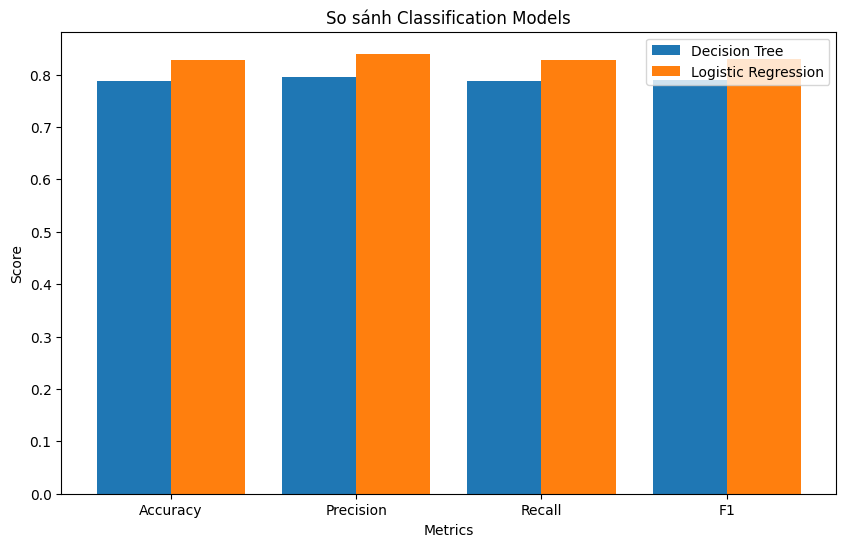

In [15]:
# So sánh kết quả của hai mô hình classification
results = pd.DataFrame([dt_result, lr_result])  # Tạo DataFrame từ kết quả của 2 mô hình để dễ so sánh
print("\nSo sánh:")  # In tiêu đề
print(results)  # In bảng so sánh các metrics của 2 mô hình

# Vẽ biểu đồ so sánh trực quan các metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']  # Danh sách các metrics cần so sánh
x = range(len(metrics))  # Tạo vị trí x cho các cột trong biểu đồ

plt.figure(figsize=(10, 6))  # Tạo figure với kích thước 10x6 inches
# Vẽ cột cho Decision Tree, offset -0.2 để tránh chồng lấp
plt.bar([i-0.2 for i in x], [dt_result[m] for m in metrics], 0.4, label='Decision Tree')
# Vẽ cột cho Logistic Regression, offset +0.2
plt.bar([i+0.2 for i in x], [lr_result[m] for m in metrics], 0.4, label='Logistic Regression')
plt.xlabel('Metrics')  # Nhãn trục x
plt.ylabel('Score')    # Nhãn trục y
plt.title('So sánh Classification Models')  # Tiêu đề biểu đồ
plt.xticks(x, metrics)  # Đặt nhãn cho các vị trí trên trục x

plt.legend()  # Hiển thị chú thích
plt.show()    # Hiển thị biểu đồ

## 2. Cross-Validation cho Random Forest

In [16]:
# Đánh giá Random Forest bằng Cross-Validation để kiểm tra độ ổn định
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Tạo Random Forest với 100 cây quyết định
cv_scores = cross_val_score(rf, X, y_class, cv=5, scoring='accuracy')  # Chạy 5-fold cross-validation với metric accuracy

print("Random Forest Cross-Validation (k=5):")  # In tiêu đề
print(f"Scores: {cv_scores}")  # In accuracy score của từng fold (5 giá trị)
print(f"Mean: {cv_scores.mean():.3f}")  # In accuracy trung bình của 5 folds
print(f"Std: {cv_scores.std():.3f}")   # In độ lệch chuẩn để đánh giá độ ổn định (càng thấp càng ổn định)
print(f"Range: {cv_scores.min():.3f} - {cv_scores.max():.3f}")  # In khoảng giá trị min-max của accuracy

Random Forest Cross-Validation (k=5):
Scores: [0.84246575 0.83219178 0.80479452 0.84931507 0.81506849]
Mean: 0.829
Std: 0.017
Range: 0.805 - 0.849


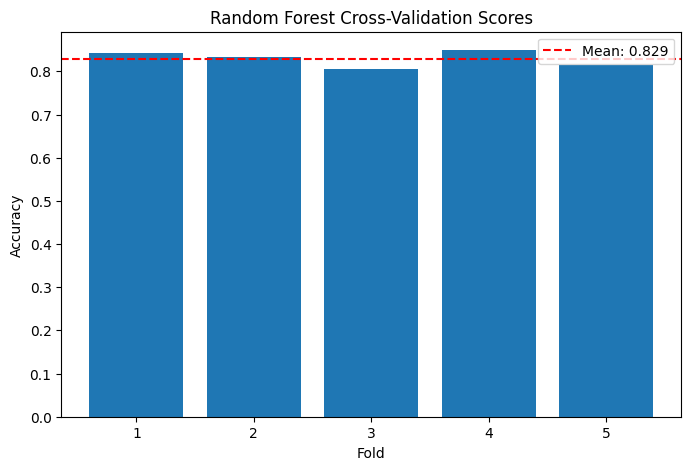

In [25]:
# Vẽ biểu đồ hiển thị kết quả Cross-Validation
plt.figure(figsize=(8, 5))  # Tạo figure với kích thước 8x5 inches
plt.bar(range(1, 6), cv_scores)  # Vẽ bar chart cho 5 folds (từ 1 đến 5)
# Vẽ đường ngang màu đỏ biểu thị giá trị accuracy trung bình
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.xlabel('Fold')  # Nhãn trục x (số thứ tự fold)
plt.ylabel('Accuracy')  # Nhãn trục y (giá trị accuracy)
plt.title('Random Forest Cross-Validation Scores')  # Tiêu đề biểu đồ
plt.legend()  # Hiển thị chú thích cho đường mean
plt.show()    # Hiển thị biểu đồ

# print(" Tất cả cột đều cao = model hiệu suất tốt")

# # GIẢI THÍCH BIỂU ĐỒ:print(" Độ lệch chuẩn thấp = model không bị overfitting")

# print("\nPHÂN TÍCH BIỂU ĐỒ CROSS-VALIDATION:")
# print(" Độ cao cột gần bằng nhau = model ổn định")

# print(" Trục X: Số thứ tự fold (1, 2, 3, 4, 5)")
# print(" Đường đỏ đứt nét: Accuracy trung bình của 5 folds")

# print(" Trục Y: Accuracy score của từng fold") 
# print(" Cột xanh: Kết quả accuracy của mỗi fold riêng biệt")

## 3. Regression: Linear vs Random Forest

In [18]:
# Chia dữ liệu riêng cho bài toán regression (dự đoán giá nhà)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)  # Chia với target là SalePrice (giá thực tế)

# Chuẩn hóa dữ liệu cho Linear Regression (cần thiết vì LR nhạy cảm với scale)
scaler_reg = StandardScaler()  # Tạo scaler mới cho bài toán regression
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)  # Fit và transform tập train
X_test_reg_scaled = scaler_reg.transform(X_test_reg)       # Chỉ transform tập test (không fit lại)

print(f"Regression data - Train: {X_train_reg.shape}, Test: {X_test_reg.shape}")  # In kích thước của datasets

Regression data - Train: (1168, 8), Test: (292, 8)


In [19]:
# Hàm đánh giá hiệu suất của mô hình regression
def evaluate_regression(model, X_tr, X_te, y_tr, y_te, name):  # Nhận mô hình, dữ liệu và tên mô hình
    model.fit(X_tr, y_tr)  # Huấn luyện mô hình trên tập train
    y_pred = model.predict(X_te)  # Dự đoán giá nhà trên tập test
    
    # Tính toán các metrics cho regression
    mae = mean_absolute_error(y_te, y_pred)  # MAE: sai số tuyệt đối trung bình (càng thấp càng tốt)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))  # RMSE: căn bậc 2 của MSE (penalize lỗi lớn nhiều hơn)
    r2 = r2_score(y_te, y_pred)  # R²: coefficient of determination (0-1, càng gần 1 càng tốt)
    
    # In kết quả với format tiền tệ dễ đọc
    print(f"\n{name}:")  # In tên mô hình
    print(f"MAE: ${mae:,.0f}")   # In MAE với format tiền và dấu phẩy phân cách
    print(f"RMSE: ${rmse:,.0f}") # In RMSE với format tiền và dấu phẩy phân cách
    print(f"R²: {r2:.3f}")       # In R² với 3 chữ số thập phân

    # Trả về dictionary chứa kết quả
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2}

In [20]:
# Khởi tạo và huấn luyện các mô hình regression
lr_reg = LinearRegression()  # Tạo mô hình Linear Regression (giả định quan hệ tuyến tính)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)  # Tạo Random Forest Regressor với 100 cây

# Đánh giá hiệu suất của từng mô hình regression
lr_reg_result = evaluate_regression(lr_reg, X_train_reg_scaled, X_test_reg_scaled, y_train_reg, y_test_reg, "Linear Regression")  # Đánh giá Linear Regression trên dữ liệu đã chuẩn hóa
rf_reg_result = evaluate_regression(rf_reg, X_train_reg, X_test_reg, y_train_reg, y_test_reg, "Random Forest")  # Đánh giá Random Forest trên dữ liệu gốc (không cần chuẩn hóa)


Linear Regression:
MAE: $25,124
RMSE: $39,608
R²: 0.795

Random Forest:
MAE: $19,045
RMSE: $28,871
R²: 0.891


In [ ]:
# So sánh kết quả regression của hai mô hình
reg_results = pd.DataFrame([lr_reg_result, rf_reg_result])  # Tạo DataFrame so sánh kết quả
print("\nSo sánh Regression:")  # In tiêu đề
print(reg_results)  # In bảng so sánh các metrics regression

# Tính phần trăm cải thiện của Random Forest so với Linear Regression
mae_improve = (lr_reg_result['MAE'] - rf_reg_result['MAE']) / lr_reg_result['MAE'] * 100  # % giảm MAE (giảm là tốt)
rmse_improve = (lr_reg_result['RMSE'] - rf_reg_result['RMSE']) / lr_reg_result['RMSE'] * 100  # % giảm RMSE (giảm là tốt)
r2_improve = (rf_reg_result['R²'] - lr_reg_result['R²']) / lr_reg_result['R²'] * 100  # % tăng R² (tăng là tốt)

print(f"\nCải thiện của Random Forest so với Linear Regression:")  # In tiêu đề kết quả cải thiện
print(f"MAE: {mae_improve:.1f}%")   # In % cải thiện MAE (giảm bao nhieu %)
print(f"RMSE: {rmse_improve:.1f}%") # In % cải thiện RMSE (giảm bao nhieu %)
print(f"R²: {r2_improve:.1f}%")     # In % cải thiện R² (tăng bao nhieu %)


So sánh Regression:
               Model           MAE          RMSE        R²
0  Linear Regression  25123.511760  39608.483601  0.795467
1      Random Forest  19044.802755  28871.167749  0.891329

Cải thiện của Random Forest so với Linear Regression:
MAE: 24.2%
RMSE: 27.1%
R²: 12.1%


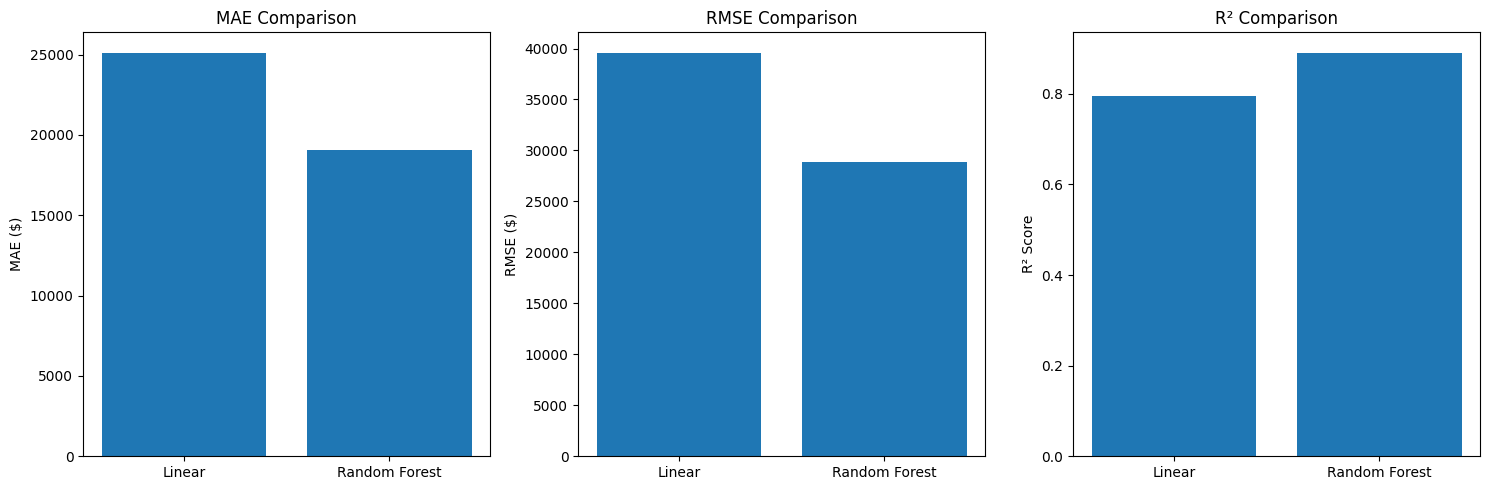

In [26]:
# Vẽ biểu đồ so sánh trực quan 3 metrics regression
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Tạo 3 subplot ngang với kích thước 15x5 inches

# Subplot 1: So sánh MAE (Mean Absolute Error)
axes[0].bar(['Linear', 'Random Forest'], [lr_reg_result['MAE'], rf_reg_result['MAE']])  # Bar chart so sánh MAE
axes[0].set_title('MAE Comparison')  # Tiêu đề subplot MAE
axes[0].set_ylabel('MAE ($)')        # Nhãn trục y với đơn vị tiền tệ

# Subplot 2: So sánh RMSE (Root Mean Square Error)
axes[1].bar(['Linear', 'Random Forest'], [lr_reg_result['RMSE'], rf_reg_result['RMSE']])  # Bar chart so sánh RMSE
axes[1].set_title('RMSE Comparison')  # Tiêu đề subplot RMSE
axes[1].set_ylabel('RMSE ($)')       # Nhãn trục y với đơn vị tiền tệ

# Subplot 3: So sánh R² (Coefficient of Determination)
axes[2].bar(['Linear', 'Random Forest'], [lr_reg_result['R²'], rf_reg_result['R²']])  # Bar chart so sánh R²
axes[2].set_title('R² Comparison')  # Tiêu đề subplot R²
axes[2].set_ylabel('R² Score')      # Nhãn trục y cho R² (không có đơn vị, thang 0-1)

plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các subplot để tránh chồng lấp
plt.show()          # Hiển thị toàn bộ biểu đồ


## 4. Kết Luận

### Kỹ thuật:
- **Random Forest tốt hơn**: Xử lý non-linear relationships, robust với outliers
- **Cross-validation ổn định**: Mean score cao, variance thấp
- **Metrics cải thiện**: MAE, RMSE thấp hơn, R² cao hơn

### Nghiệp vụ:
- **Dự đoán chính xác giá**: Giúp quyết định đầu tư đúng
- **Quản lý rủi ro**: Ngân hàng đánh giá tài sản thế chấp
- **Ứng dụng thực tế**: Định giá tự động, phân tích thị trường
- **Hiệu quả chi phí**: Giảm thời gian định giá thủ công

##  Hướng dẫn đọc biểu đồ Machine Learning

### Nguyên tắc chung:

**Classification Models (Phân loại):**
- Tất cả metrics từ 0-1, **càng cao càng tốt**
- Accuracy > 0.8 = tốt, > 0.9 = rất tốt
- So sánh các cột để chọn model

**Regression Models (Dự đoán số):**
- MAE & RMSE: **càng thấp càng tốt** (sai số ít)
- R²: **càng cao càng tốt** (giải thích nhiều)
- RMSE > MAE = có outliers (dự đoán sai rất xa)

**Cross-Validation:**
- Cột cao đều = model ổn định
- Cột chênh lệch = model không tin cậy
- Đường mean = hiệu suất trung bình

### Tips phân tích:
1. **Nhìn trước tiên:** Xu hướng chung (tăng/giảm)
2. **Nhìn tiếp theo:** Độ chênh lệch giữa các model
3. **Kết luận:** Model nào nhất quán tốt nhất

In [24]:
# Tổng kết toàn bộ phân tích machine learning
print("=" * 50)  # In đường kẻ trang trí
print("           TỔNG KẾT KẾT QUẢ")  # In tiêu đề chính
print("=" * 50)  # In đường kẻ trang trí

print("\n1. CLASSIFICATION:")  # In tiêu đề phần classification
# So sánh accuracy để tìm mô hình tốt nhất cho classification
best_class = 'Decision Tree' if dt_result['Accuracy'] > lr_result['Accuracy'] else 'Logistic Regression'
print(f"   Tốt nhất: {best_class}")  # In mô hình classification có hiệu suất cao nhất

print("\n2. CROSS-VALIDATION:")  # In tiêu đề phần cross-validation
print(f"   Random Forest CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")  # In mean ± std của CV scores (thể hiện hiệu suất và độ ổn định)

print("\n3. REGRESSION:")  # In tiêu đề phần regression
# So sánh R² để tìm mô hình tốt nhất cho regression
best_reg = 'Random Forest' if rf_reg_result['R²'] > lr_reg_result['R²'] else 'Linear Regression'
print(f"   Tốt nhất: {best_reg}")  # In mô hình regression có hiệu suất cao nhất
print(f"   R² improvement: {r2_improve:.1f}%")  # In % cải thiện R² của Random Forest so với Linear Regression

print("\n4. KHUYẾN NGHỊ:")  # In tiêu đề phần khuyến nghị
print("   → Random Forest: Versatile và hiệu quả nhất")  # Khuyến nghị sử dụng Random Forest

print("   → Phù hợp cho production deployment")           # Lý do khuyến nghị (phù hợp thực tế)
print("=" * 50)  # In đường kẻ kết thúc

           TỔNG KẾT KẾT QUẢ

1. CLASSIFICATION:
   Tốt nhất: Logistic Regression

2. CROSS-VALIDATION:
   Random Forest CV: 0.829 ± 0.017

3. REGRESSION:
   Tốt nhất: Random Forest
   R² improvement: 12.1%

4. KHUYẾN NGHỊ:
   → Random Forest: Versatile và hiệu quả nhất
   → Phù hợp cho production deployment
